<a href="https://colab.research.google.com/github/heathlikethecandybar/phase_5/blob/main/phase_5_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Diabetes

#Overview

##Business Problem

An insurance company wants to develop a predictive model to assess the risk of diabetes among their policyholders based on a limited set of available data points. By accurately identifying individuals at high risk of developing diabetes, the company aims to take proactive measures to reduce healthcare costs and improve the overall health outcomes of their customers.

The challenge for the company is to build a robust and accurate predictive model that can handle the complexity and non-linear relationships between the available data points and the risk of developing diabetes. The model should consider factors such as age, gender, BMI, hypertension status, heart disease history, smoking history, HbA1c level, and blood glucose level. We will use a classification model to predict diabetes within the population of interest.

My background and work history has been in healthcare which makes this an interesting problem for me.  Being able to accurately predict risk within a population and provide resources and preventive measures are important now more than ever.

##Evaluation Metrics

Recall (Sensitivity) calculates the proportion of correctly predicted positive instances (true positives) out of the total actual positive instances (true positives + false negatives). It focuses on the ability of the model to identify all positive instances, which, in this case, would be individuals with diabetes. Maximizing recall helps ensure that individuals who are at risk of or have diabetes are correctly identified, enabling appropriate interventions and healthcare management.

By emphasizing recall, you aim to minimize false negatives and avoid missing individuals who need early interventions or treatments. However, it's important to note that focusing on recall might lead to a higher number of false positives. Therefore, it's essential to strike a balance that aligns with the specific goals and requirements of your business context.

## About the Data
The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

#Data Acquisition

##Importing our packages for EDA

In [1]:
#! pip install scikit-learn==1.2.2



In [2]:
#importing necessary packages for light EDA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer, make_column_selector
from sklearn.dummy import DummyClassifier
import sklearn.metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline as ImPipeline


##Setting up our Kaggle data file pull

In [3]:
#mounting google drive for easy access to our downloaded kaggle data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#making directory for kaggle
! mkdir ~/.kaggle

In [5]:
#copying my json file to new directory
! cp /content/drive/MyDrive/Flatiron/Capstone/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
#changing access to our kaggle file
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#downloading our kaggle dataset
! kaggle datasets download iammustafatz/diabetes-prediction-dataset

100% 734k/734k [00:00<00:00, 1.57MB/s]
100% 734k/734k [00:00<00:00, 1.56MB/s]


In [8]:
#unzipping our file
!unzip -q /content/drive/MyDrive/Flatiron/Capstone/diabetes_prediction/diabetes-prediction-dataset.zip -d /content/Dataset

##Importing data

In [9]:
#attaching our csv to a pandas dataframe
df = pd.read_csv('/content/Dataset/diabetes_prediction_dataset.csv')

#Exploratory Data Analysis

In [10]:
#quick look at our data
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
#loop through each column in the df
for column in df.columns:
    distinct_values = df[column].unique()
    print(f"Column: {column}")
    print(f"Distinct Values: {distinct_values}")
    print("--------------------------")

Column: gender
Distinct Values: ['Female' 'Male' 'Other']
--------------------------
Column: age
Distinct Values: [80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]
--------------------------
Column: hypertension
Distinct Values: [0 1]
--------------------------
Column: heart_disease
Distinct Values: [1 0]
--------------------------
Column: smoking_history
Distinct Values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
---

Looks like we will have 7 independent variables, and 1 dependent variable (target) which is our diabetes column.  Hypertension, heart disease, and smoking history are categorical values.  In which we may need to one encode.

In [12]:
#taking a look at our data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [13]:
#look for missing records
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

No missing records which is good.  100k records, which is a good sized data set.  I wish there was more interesting columns, however, these are the core tenants for predicting diabetes.

In [14]:
#summary stats
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Roughly 8.5% of the population in this dataset has been diagnosed with Diabetes.  It wasn't explicitly stated, but based ont this number, I am assuming that this is based on type 2 diabetes diagnoses.  Average age is 42 years of age, roughly 7.5% of the population has been diagnosed with hypertension, and 4% diagnosed with heart disease.  The average Body Mass Index (BMI) is 27, which is considered overweight.  The blood glucose level is 138 and HbA1c level is 5.5 on average.  For non-diabetics, the normal HbA1c level ranges between 4% and 5.6%. Levels between 5.7% and 6.4% indicate prediabetes and a greater possibility of diabetes. HbA1c of 6.5% or greater indicates diabetes.  Also looks like we have some weird decimals for our ages.  I am going to round those down to the nearest whole number.

In [15]:
#rounding down the age to nearest whole number and adjusting data type to int
df.loc[:, 'age'] = np.floor(df.loc[:, 'age']).astype(int)

<ipython-input-15-f15dd1e25e97>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'age'] = np.floor(df.loc[:, 'age']).astype(int)


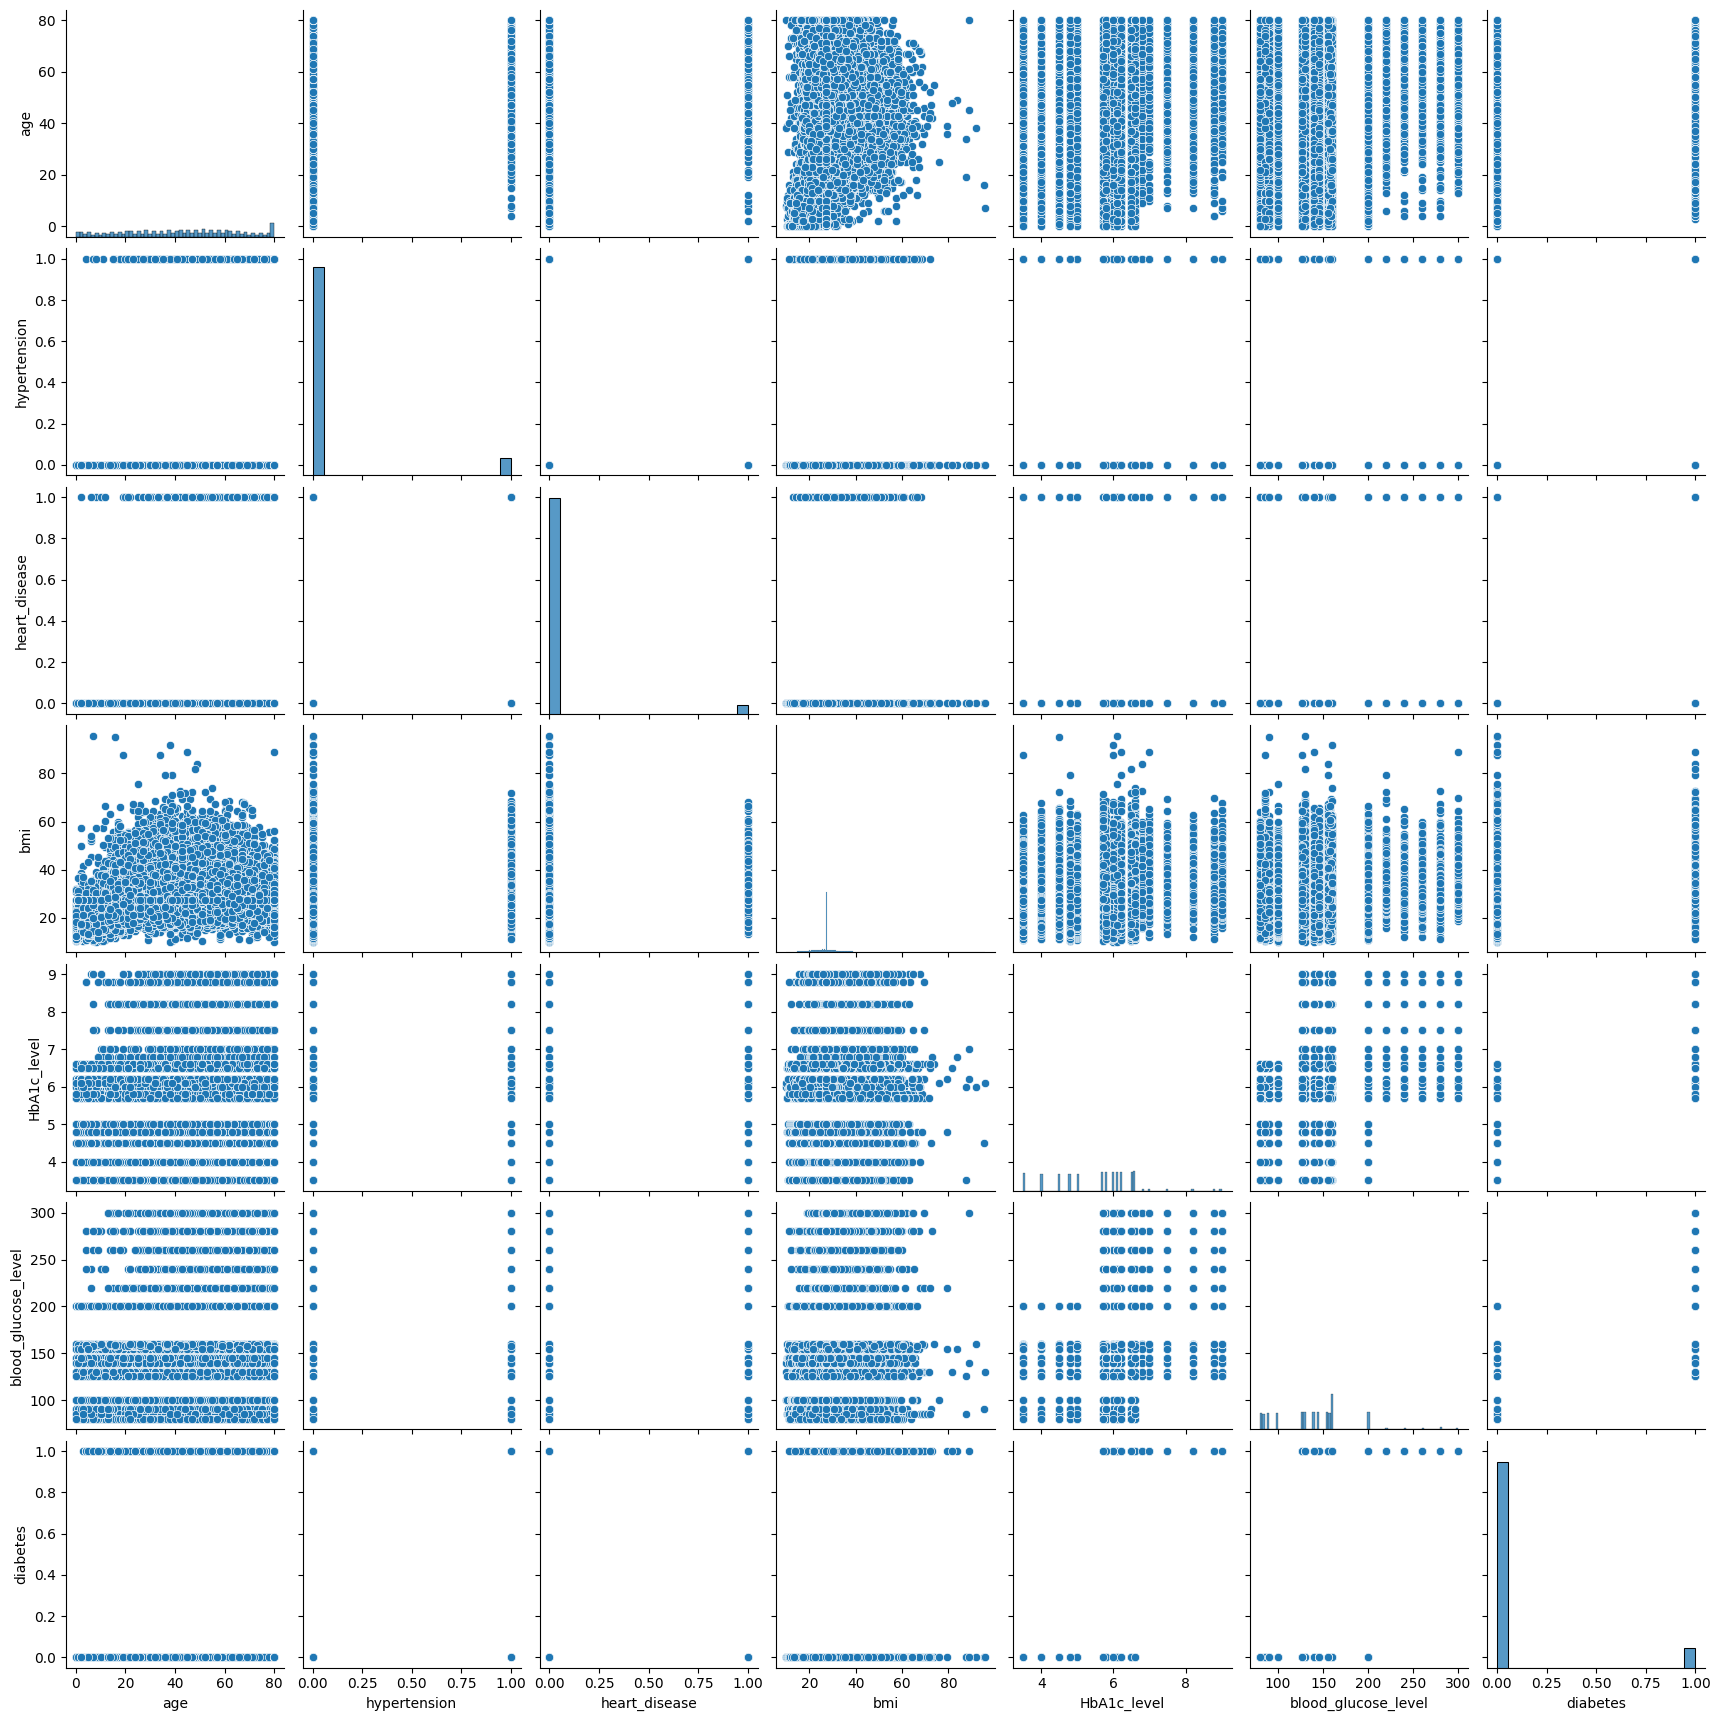

In [16]:
#distribution by column
sns.pairplot(df)

Looks like our target is imbalanced, so we will most likely be using an oversampling method such as smote to deal with the imbalance.  This seems to be the case even with some of our independent variables.  Which makes sense when you think about the distribution of the population with heart disease, hypertension, and diabetes.

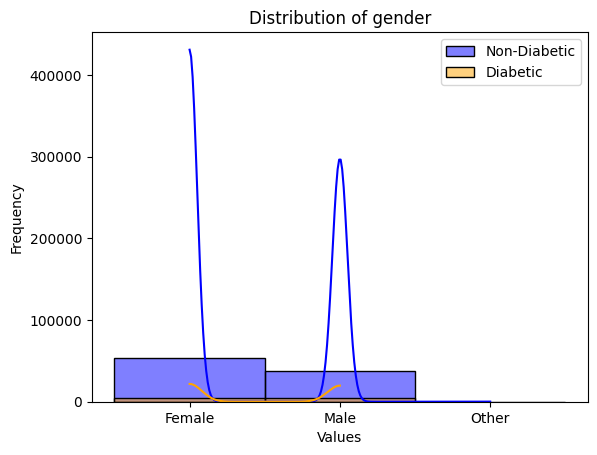

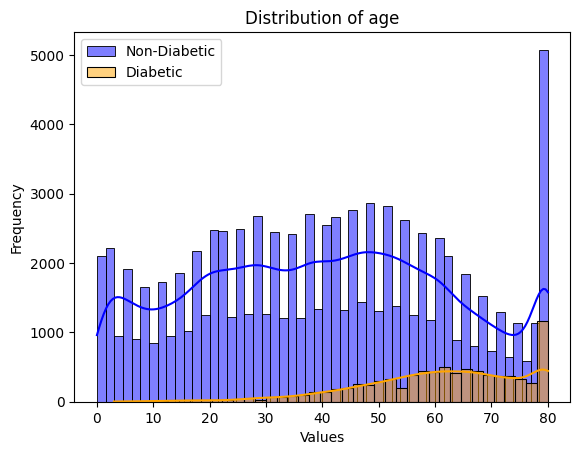

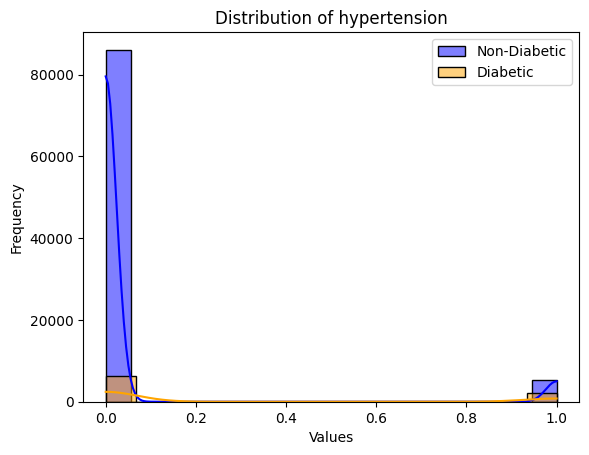

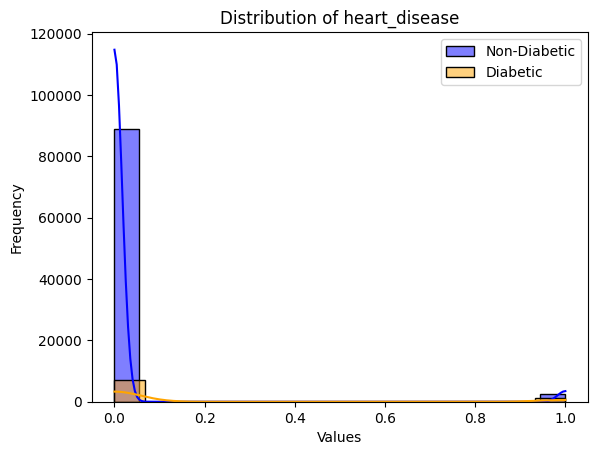

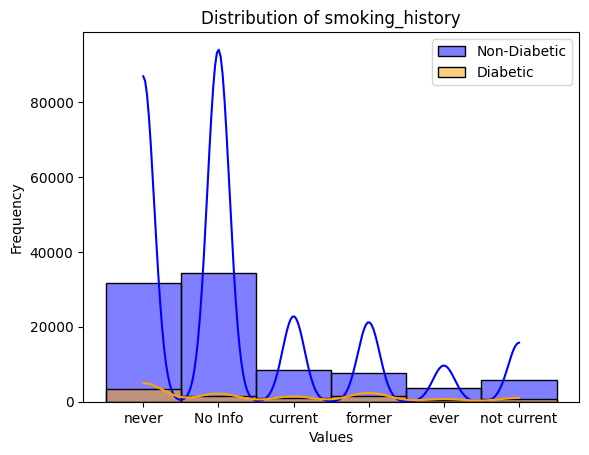

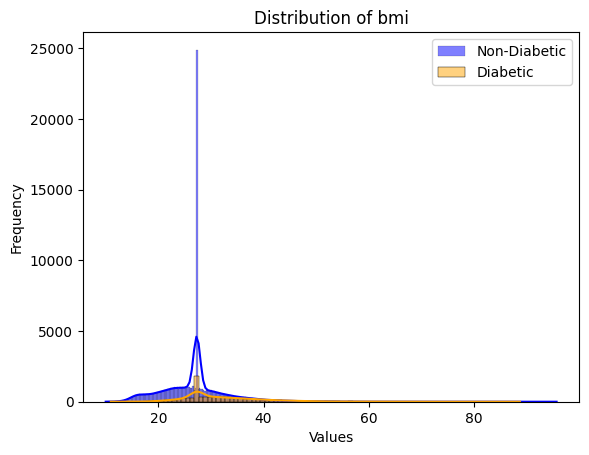

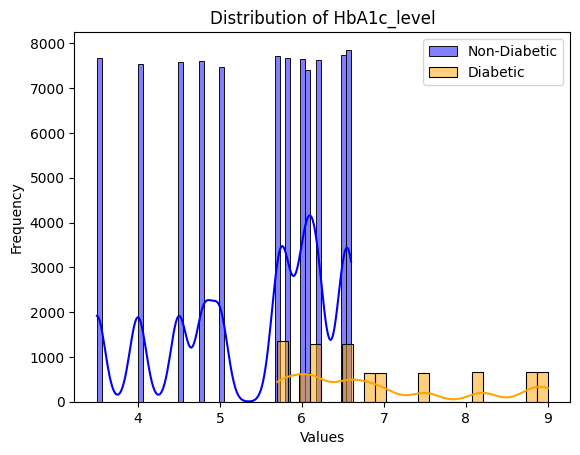

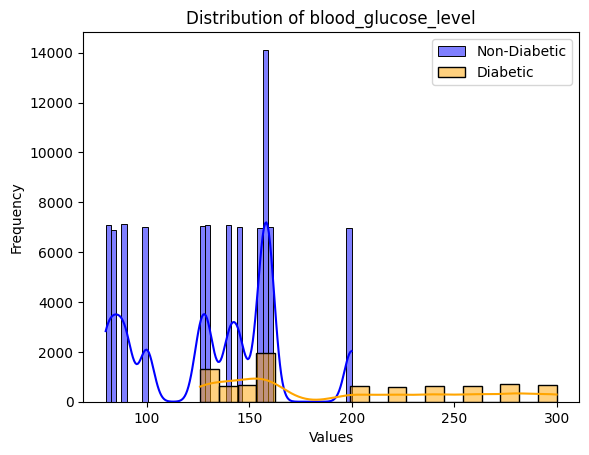

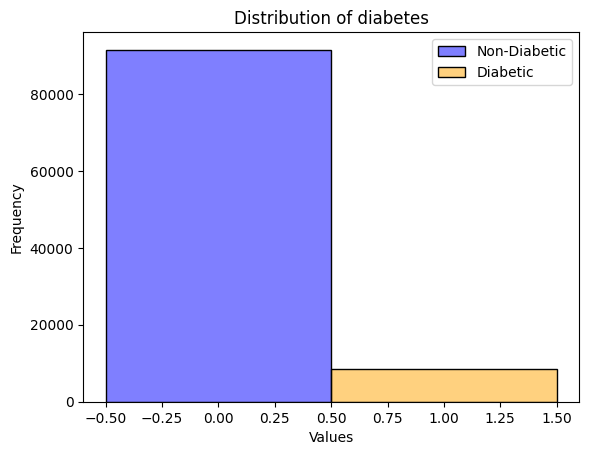

In [17]:
#set the color palette
sns.set_palette("RdGy")

#get the list of column names
columns = df.columns

#create individual distribution plots for each column based on the binary column
for column in columns:
    plt.figure()
    sns.histplot(df[df['diabetes'] == 0][column], kde=True, color='blue', label='Non-Diabetic')
    sns.histplot(df[df['diabetes'] == 1][column], kde=True, color='orange', label='Diabetic')
    plt.title(f'Distribution of {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()

These displays further display our insights from above in our quick statistical analysis of the data.  This shows the distribution between diabetics and non-diabetics more clearly.  For instnace blood glucose levels for diabetics typically never go below 130.  Or HbA1c levels typically don't dip below roughly 5.8%.  BMI Has a major outlier that we will want to remove or impute.  And age shows the skew towards older ages more likely diagnosed starting around mid 30s.

In [18]:
#creating a function to make charting easier as I move through the different categories.  Some of these visuals will be duplicative of the charting above.
def mini_bar(x, y, x_title, y_title, plot_title):
    mean_df = df[[x, y]].groupby(x, as_index=False).mean()
    count_df = df[x].value_counts().reset_index()
    count_df.columns = [x, 'Count']

    mean_df = mean_df.merge(count_df, on=x)

    print(mean_df)

    #bar plot to visualize
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1 = sns.barplot(x=x, y=y, data=mean_df, ax=ax1)
    ax1.set_ylabel(y_title)
    ax1.set_xlabel(x_title)
    ax1.set_title(plot_title)
    plt.xticks(rotation='vertical')

    #define the percentage formatter function
    def percent_formatter(x, pos):
        return f'{x * 100:.0f}%'

    #set the y-axis formatter
    formatter = mtick.FuncFormatter(percent_formatter)
    ax1.yaxis.set_major_formatter(formatter)

    #add a second axis for the count
    ax2 = ax1.twinx()
    ax2.plot(count_df[x], count_df['Count'], color='gray', marker='o', linestyle='', markersize=8)
    ax2.set_ylabel('# of Cases')

    #display the plot
    plt.show()

   gender  diabetes  Count
0  Female  0.076189  58552
1    Male  0.097490  41430
2   Other  0.000000     18


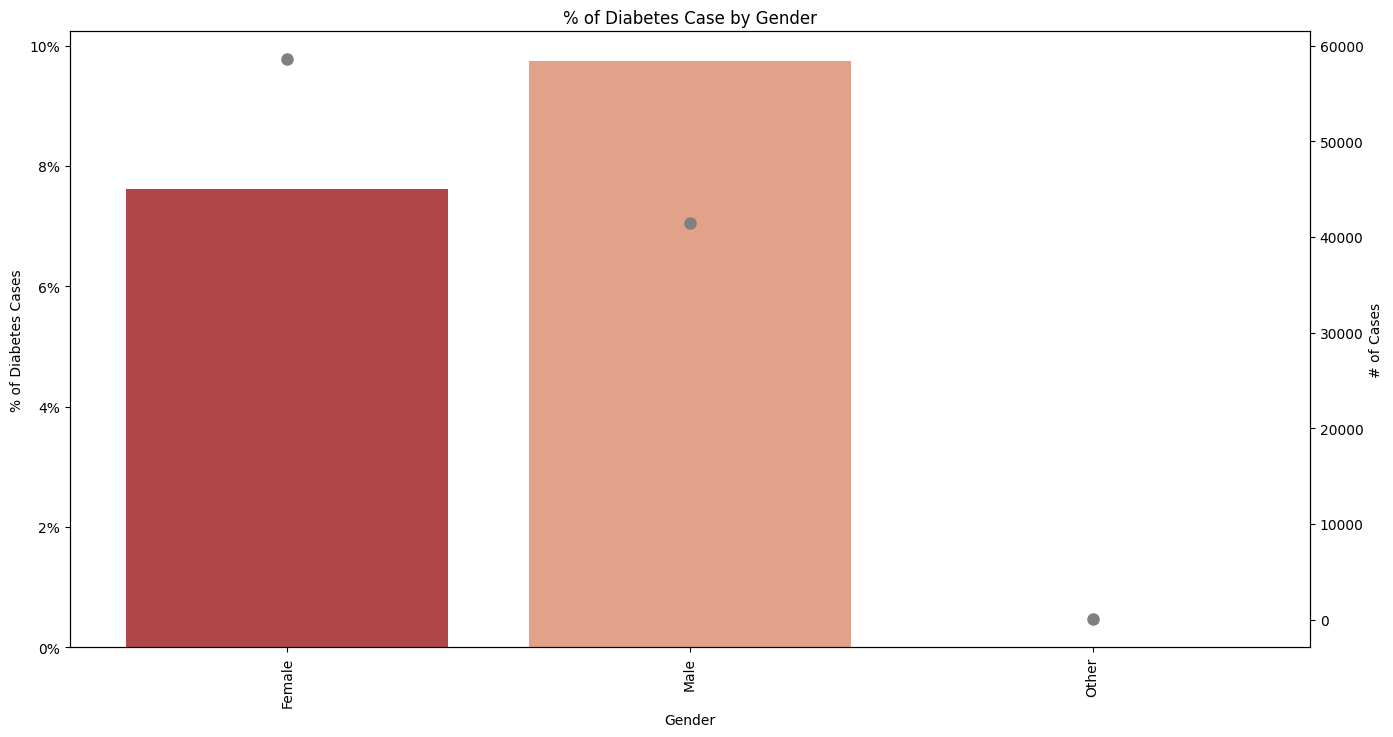

In [19]:
#visualizing the relationship
mini_bar('gender', 'diabetes', 'Gender', '% of Diabetes Cases', '% of Diabetes Case by Gender')

Males typically have a higher prevalence of diabetes than femals, and vs other genders.  According to one source, men have had slightly higher rates of diabetes than women. However, the difference in prevalence between genders is not substantial.

    age  diabetes  Count
0     0  0.000000    911
1     1  0.000000   1190
2     2  0.000000   1186
3     3  0.000963   1038
4     4  0.006296    953
..  ...       ...    ...
76   76  0.203274    733
77   77  0.186301    730
78   78  0.199413    682
79   79  0.227053    621
80   80  0.182174   5621

[81 rows x 3 columns]


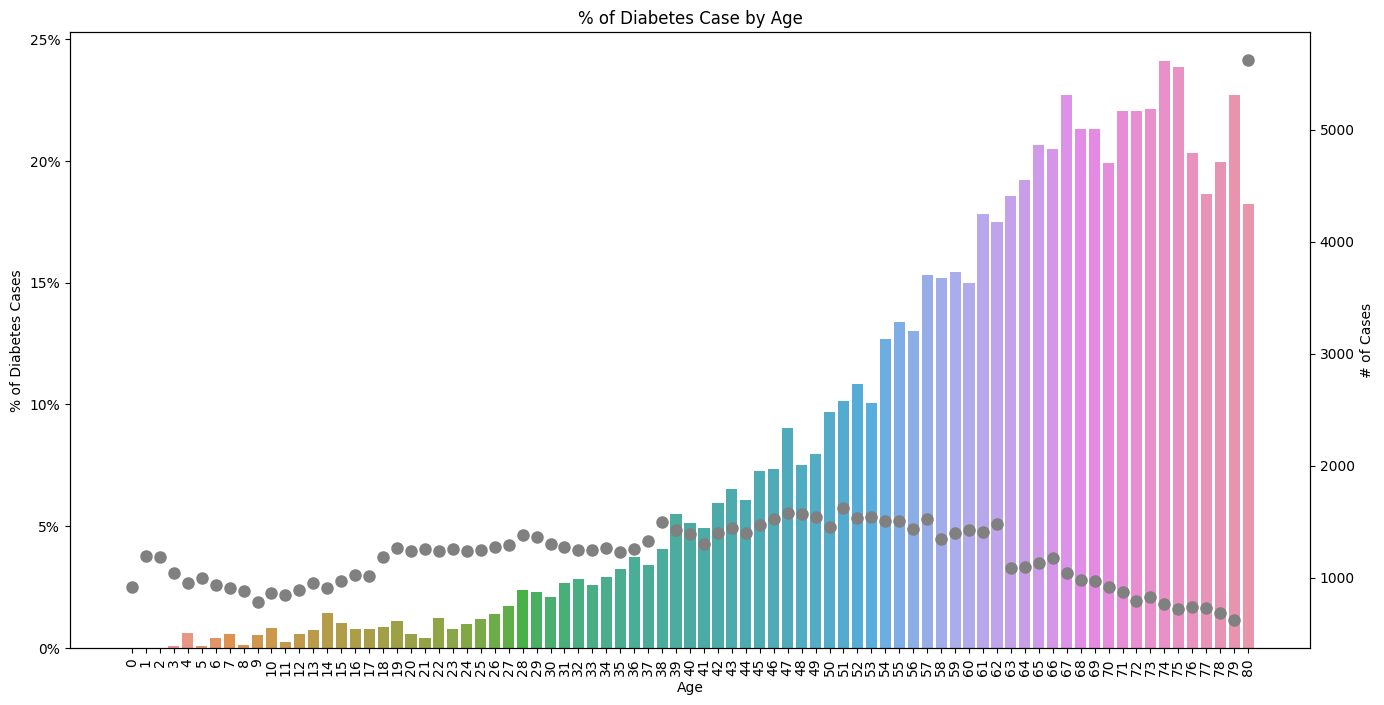

In [20]:
# Visualizing the relationship

mini_bar('age', 'diabetes', 'Age', '% of Diabetes Cases', '% of Diabetes Case by Age');

This distbrition of prevalence by age shows us the increasing diabetest prevlance as age increases.  This rings true with a lot of the studies that exist as the risk for other diabetes based risk factors also increase with age (i.e. heart disease, hypertension, obesity)

   hypertension  diabetes  Count
0             0  0.069308  92515
1             1  0.278958   7485


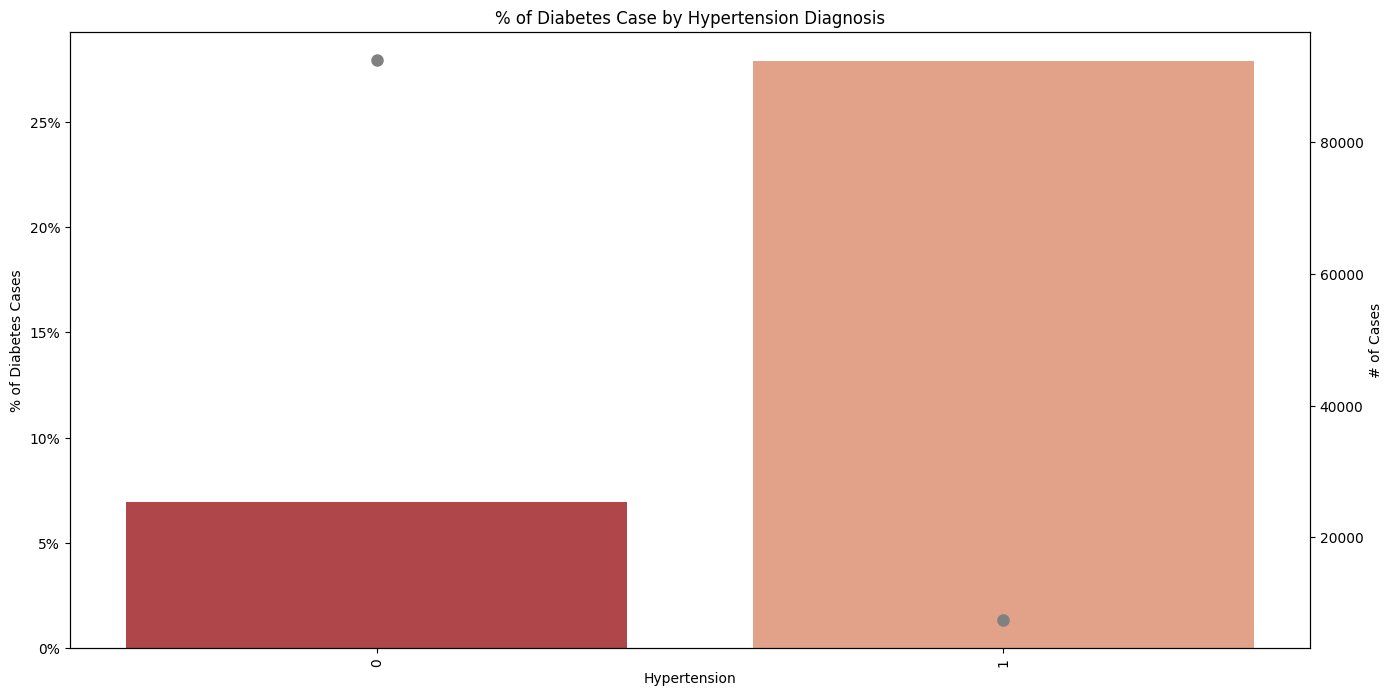

In [21]:
mini_bar('hypertension', 'diabetes', 'Hypertension', '% of Diabetes Cases', '% of Diabetes Case by Hypertension Diagnosis')

Hypertension (high blood pressure) and diabetes have a bidirectional relationship. They can worsen each other and increase the risk of cardiovascular complications. Hypertension can make it harder to control blood sugar levels, contribute to kidney damage, worsen diabetic retinopathy, and impact other organs. Managing both conditions through lifestyle changes and medications is crucial for overall health.

   heart_disease  diabetes  Count
0              0  0.075298  96058
1              1  0.321410   3942


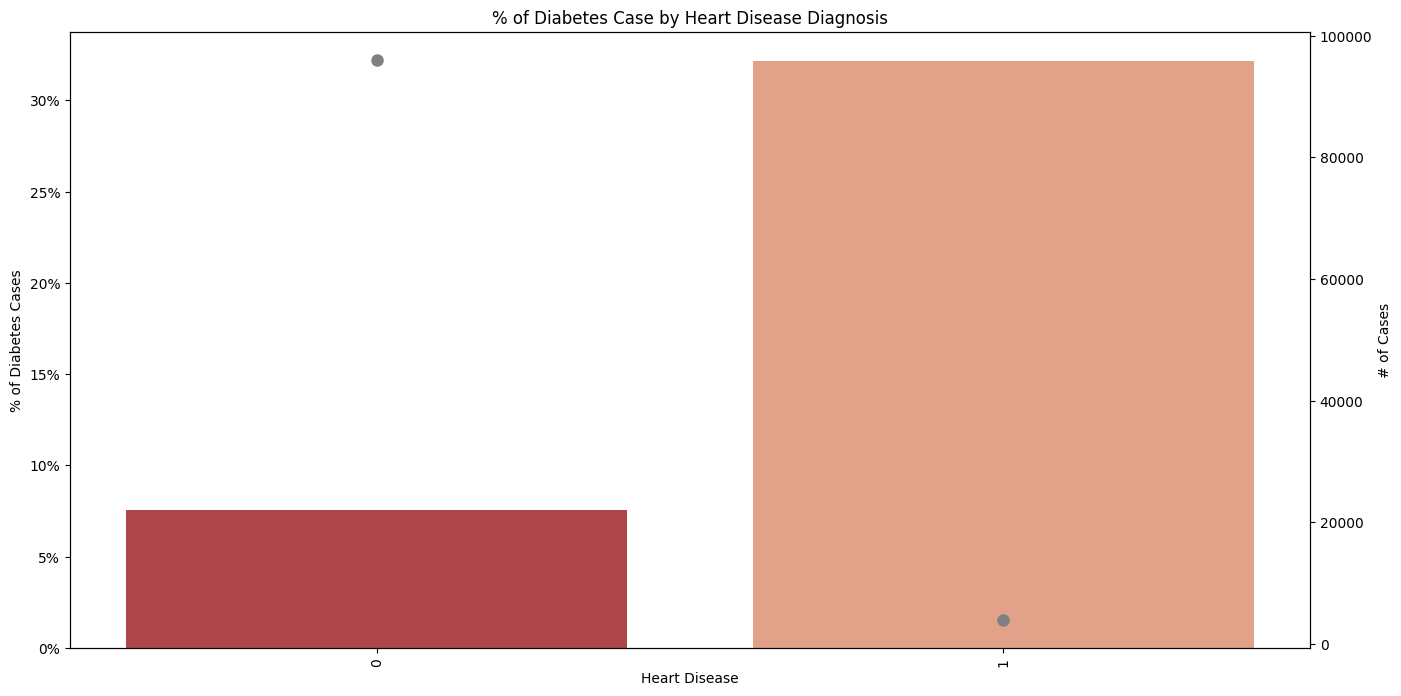

In [22]:
mini_bar('heart_disease', 'diabetes', 'Heart Disease', '% of Diabetes Cases', '% of Diabetes Case by Heart Disease Diagnosis')

Heart disease is a significant and interconnected complication of diabetes. Individuals with diabetes have an increased risk of developing heart conditions such as coronary artery disease, heart attacks, and heart failure. The presence of diabetes can accelerate the progression and severity of heart disease due to factors such as high blood sugar levels, insulin resistance, inflammation, and abnormal blood lipid levels. Shared risk factors like obesity, high blood pressure, and unhealthy cholesterol levels further contribute to the link between diabetes and heart disease.

  smoking_history  diabetes  Count
0         No Info  0.040596  35816
1         current  0.102089   9286
2            ever  0.117882   4004
3          former  0.170017   9352
4           never  0.095341  35095
5     not current  0.107027   6447


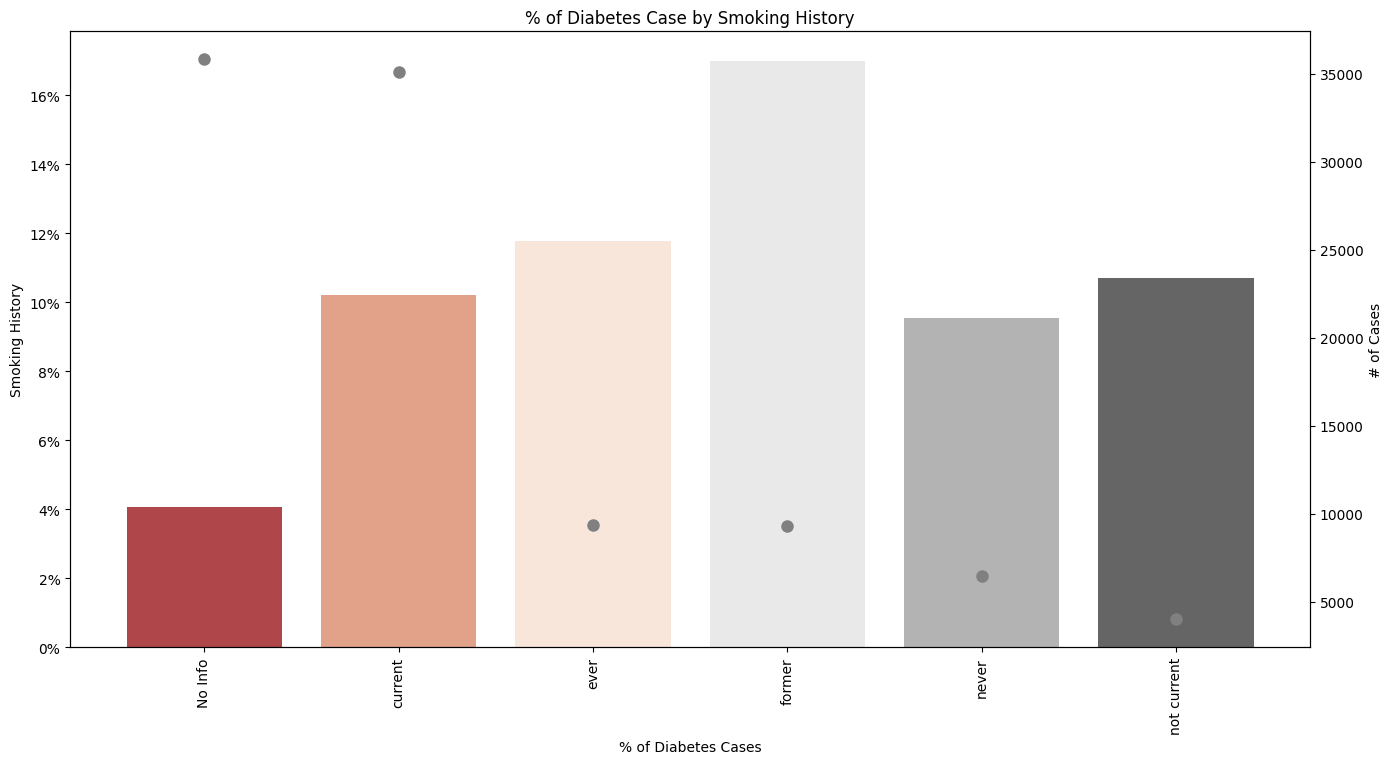

In [23]:
mini_bar('smoking_history', 'diabetes', '% of Diabetes Cases', 'Smoking History', '% of Diabetes Case by Smoking History')

The impact of smoking history on diabetes is significant. Research has shown that smoking increases the risk of developing type 2 diabetes. Smoking impairs insulin sensitivity and glucose metabolism, making it harder for the body to regulate blood sugar levels effectively. Additionally, smoking exacerbates other diabetes-related complications, such as cardiovascular disease, kidney disease, and nerve damage. Quitting smoking can greatly reduce the risk of developing diabetes and improve overall health outcomes for individuals with diabetes. It is crucial for individuals with diabetes to avoid smoking and for those who smoke to quit in order to better manage their condition and reduce associated health risks.

    HbA1c_level  diabetes  Count
0           3.5  0.000000   7662
1           4.0  0.000000   7542
2           4.5  0.000000   7585
3           4.8  0.000000   7597
4           5.0  0.000000   7471
5           5.7  0.083680   8413
6           5.8  0.079197   8321
7           6.0  0.077999   8295
8           6.1  0.080890   8048
9           6.2  0.078365   8269
10          6.5  0.073308   8362
11          6.6  0.079977   8540
12          6.8  1.000000    642
13          7.0  1.000000    634
14          7.5  1.000000    643
15          8.2  1.000000    661
16          8.8  1.000000    661
17          9.0  1.000000    654


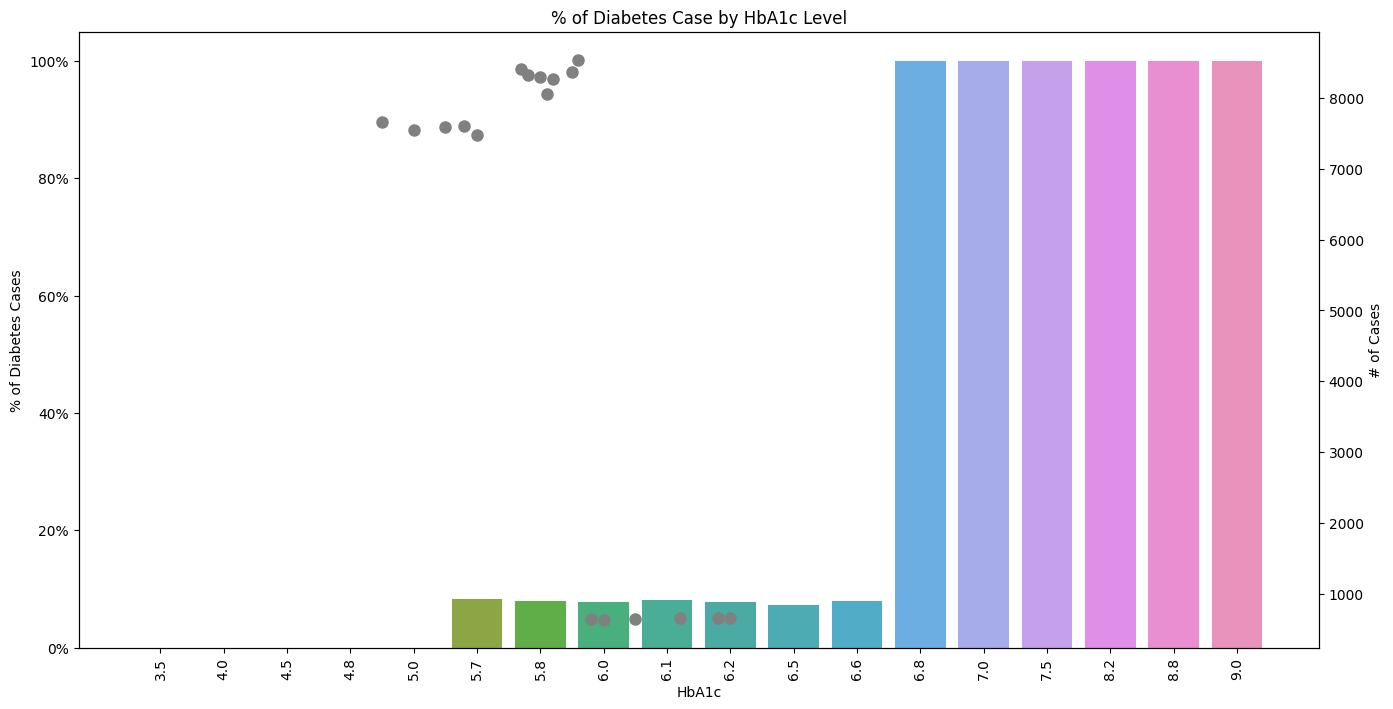

In [24]:
mini_bar('HbA1c_level', 'diabetes', 'HbA1c', '% of Diabetes Cases', '% of Diabetes Case by HbA1c Level')

HbA1c, or glycated hemoglobin, is a vital indicator in the management of diabetes. It measures the average blood sugar levels over a span of two to three months. Maintaining a target HbA1c level is crucial for individuals with diabetes as it reflects their overall blood glucose control. High HbA1c levels indicate poor diabetes management and an increased risk of diabetes-related complications. It is important to keep HbA1c within the recommended target range, as defined by healthcare professionals, to reduce the risk of long-term complications such as heart disease, kidney damage, nerve damage, and eye problems. Regular monitoring of HbA1c and adjustments to treatment plans, including medication, diet, and exercise, are essential for individuals with diabetes to achieve optimal blood sugar control and maintain good overall health.

    blood_glucose_level  diabetes  Count
0                    80  0.000000   7106
1                    85  0.000000   6901
2                    90  0.000000   7112
3                   100  0.000000   7025
4                   126  0.082576   7702
5                   130  0.088786   7794
6                   140  0.080833   7732
7                   145  0.086209   7679
8                   155  0.079076   7575
9                   158  0.000000   7026
10                  159  0.085836   7759
11                  160  0.090249   7712
12                  200  0.085132   7600
13                  220  1.000000    603
14                  240  1.000000    636
15                  260  1.000000    635
16                  280  1.000000    729
17                  300  1.000000    674


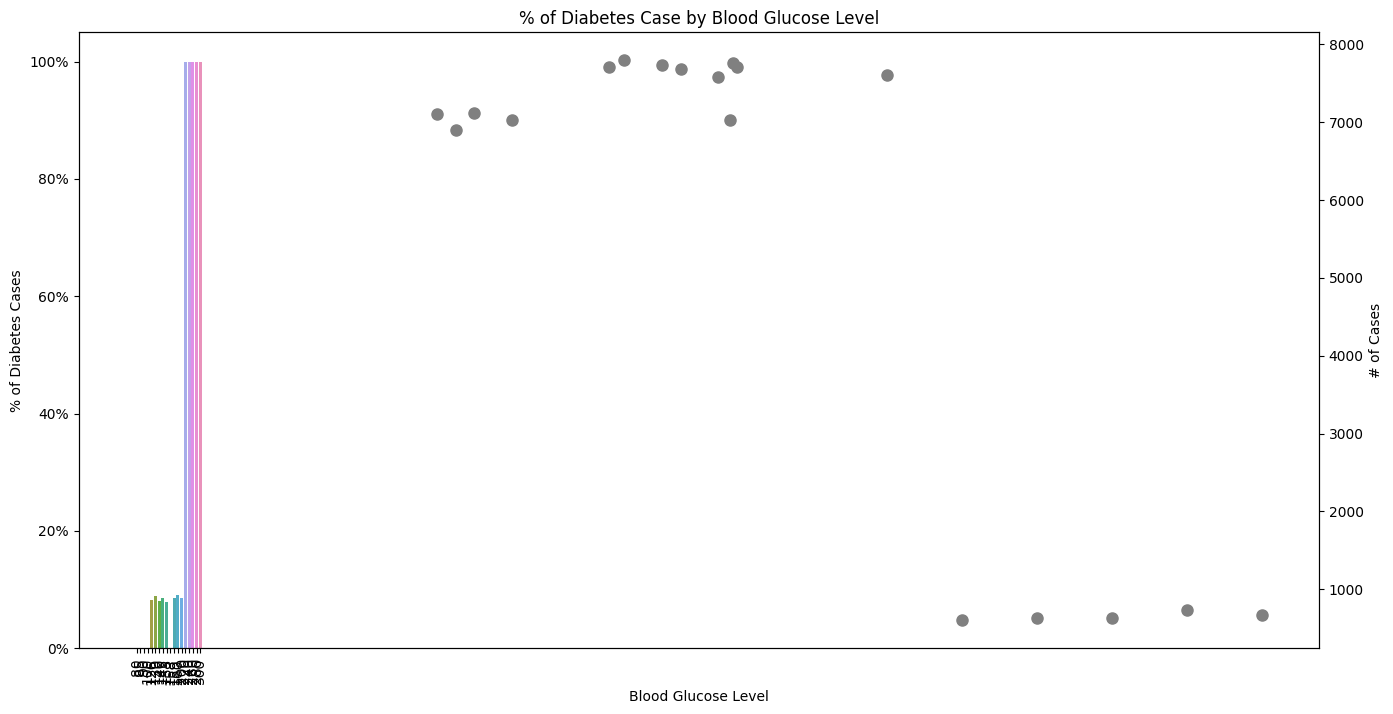

In [25]:
mini_bar('blood_glucose_level', 'diabetes', 'Blood Glucose Level', '% of Diabetes Cases', '% of Diabetes Case by Blood Glucose Level')

** Need insight here; also need to think about potentially removing blood glucose and HbA1c level from the data.  This is essentially another indicator for diabetes since such few cases under the thresholds can have diabetes, but over the threshold "guarantees" a diagnosis.

<ipython-input-26-f8584392fa96>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


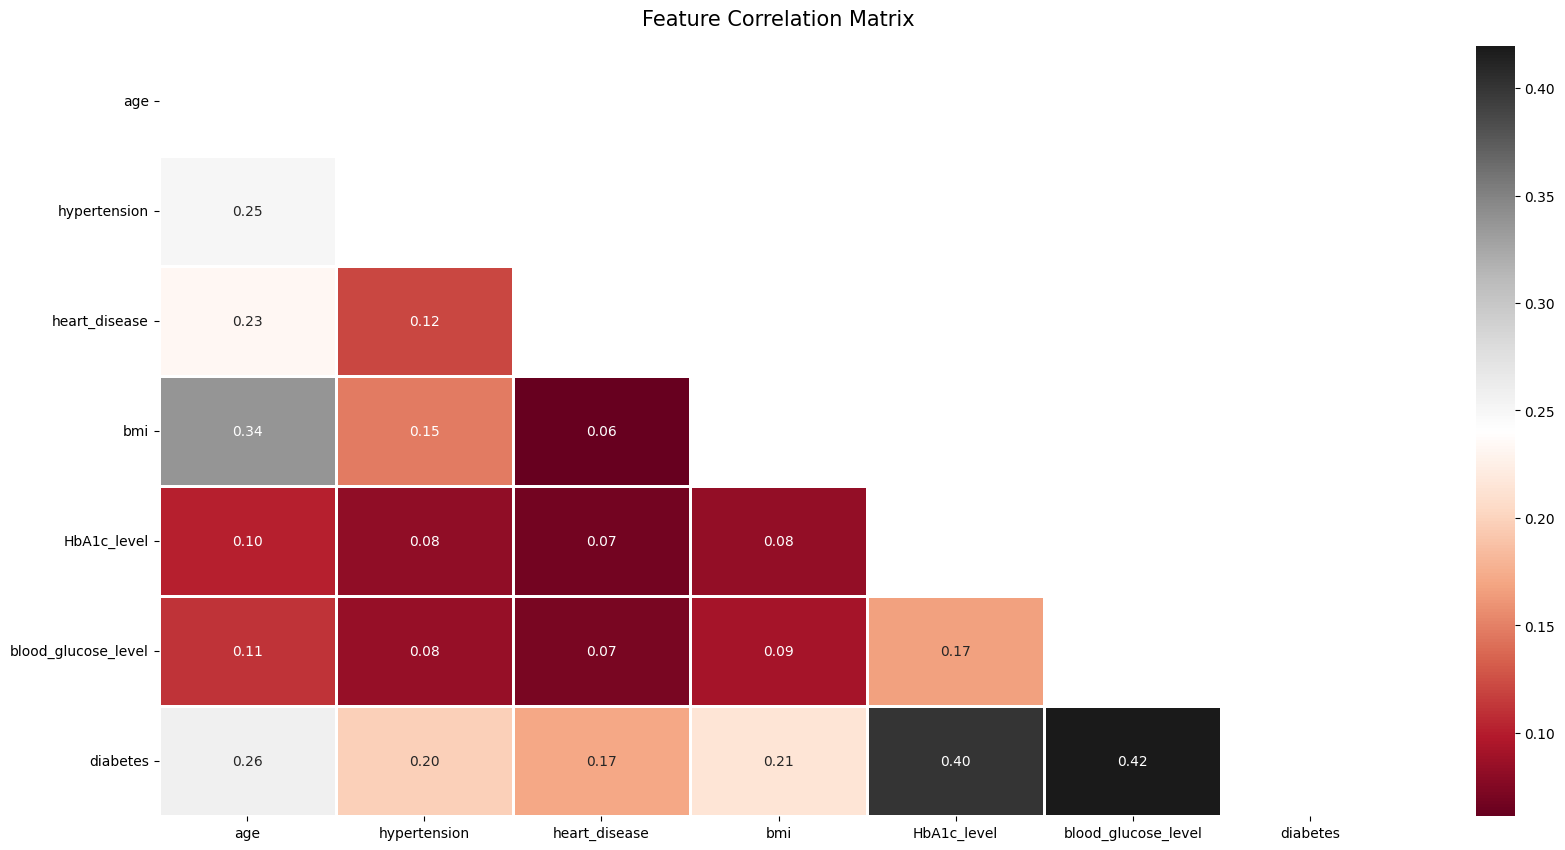

In [26]:
# Creating a heatmap to look at colinearity and potential categories that will lead to churn prediction.

corr = df.corr()

fix, ax = plt.subplots(figsize = (20,10))
matrix = np.triu(corr)
ax.set_title('Feature Correlation Matrix', pad=15, fontsize=15)
heatmap = sns.heatmap(corr, annot=True, cmap='RdGy', fmt='.2f', mask=matrix, linewidths=1)
plt.show();

As we were seeing in our EDA there is a high correlation bewteen HbA1c and blood glucose levels within diabetes cases.  Age is the 3rd highest correlated value, while BMI, hypertension and heart disease also show moderate correlations.  We also see a high correlation between age and BMI which makes sense, and hypertension and heart disease.

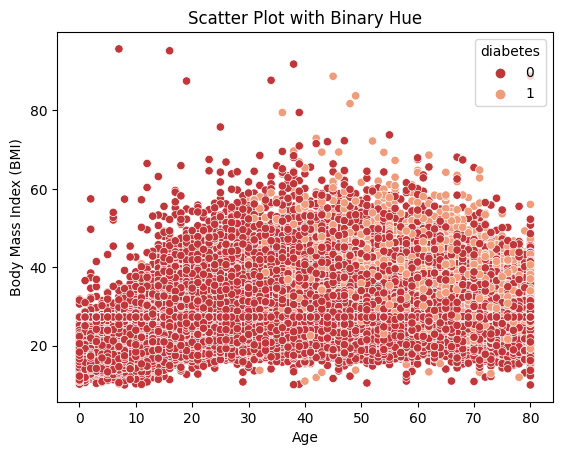

In [27]:
# Create the scatter plot
sns.scatterplot(x=df['age'], y=df['bmi'], hue=df['diabetes'])

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Body Mass Index (BMI)')
plt.title('Scatter Plot with Binary Hue')

# Display the plot
plt.show()

** Need insight here

# Classification Modelling

## Additional Cleaning

In [28]:
#because HbA1c & Blood Glucose levels are so highly correlated with the diagnosis of Diabetes, I am going to initially remove this from our modeling.
df_clean = df
df_clean.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,0,1,never,25.19,6.6,140,0
1,Female,54,0,0,No Info,27.32,6.6,80,0
2,Male,28,0,0,never,27.32,5.7,158,0
3,Female,36,0,0,current,23.45,5.0,155,0
4,Male,76,1,1,current,20.14,4.8,155,0


In [29]:
df_clean['gender'].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [30]:
df_clean = df[df['gender'] != 'Other']

In [31]:
df_clean['gender'].value_counts()

Female    58552
Male      41430
Name: gender, dtype: int64

In [32]:
#convert the categorical column to numeric using one-hot encoding
df_encoded = pd.get_dummies(df_clean, columns=['gender', 'smoking_history'], drop_first=True)
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80,0,1,25.19,6.6,140,0,0,0,0,0,1,0
1,54,0,0,27.32,6.6,80,0,0,0,0,0,0,0
2,28,0,0,27.32,5.7,158,0,1,0,0,0,1,0
3,36,0,0,23.45,5.0,155,0,0,1,0,0,0,0
4,76,1,1,20.14,4.8,155,0,1,1,0,0,0,0


In [33]:
#situate target and non-target features

X = df_encoded.drop(['diabetes'], axis=1)
y = df_encoded['diabetes']

# Create splits

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
#also looking at a dummy model with 5 cross validation folds.  Mean accuracy is about
#92%.  This aligns with our assumption above with the imbalance of our churned
#customer count.

dummy_model = DummyClassifier(strategy='most_frequent')

cv_results = cross_val_score(dummy_model,
                             X_train,
                             y_train,
                             cv=5)

dummy_model.fit(X_train, y_train)

np.mean(cv_results)

0.9158642947863254

** Need insight here

## Pipeline

In [35]:
#labeling columns for different preprocessing steps

categorical_columns = []

numerical_columns = ['age',
                     'bmi',
                     'HbA1c_level',
                     'blood_glucose_level'
                    ]

binary_columns = ['hypertension',
                  'heart_disease',
                  'smoking_history_current',
                  'smoking_history_ever',
                  'smoking_history_former',
                  'smoking_history_never',
                  'smoking_history_not current',
                  'gender_Male'
                  ]

In [36]:
#check to make sure we have all our columns accounted for
(len(categorical_columns)+len(numerical_columns)+len(binary_columns)) == (df_encoded.shape[1]-1)

True

In [37]:
#saving a copy of our data frame to reference columns later.
df_X_train_copy = X_train.iloc[:10]

df_X_test_copy = X_test.iloc[:10]

In [38]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99982 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          99982 non-null  int64  
 1   hypertension                 99982 non-null  int64  
 2   heart_disease                99982 non-null  int64  
 3   bmi                          99982 non-null  float64
 4   HbA1c_level                  99982 non-null  float64
 5   blood_glucose_level          99982 non-null  int64  
 6   diabetes                     99982 non-null  int64  
 7   gender_Male                  99982 non-null  uint8  
 8   smoking_history_current      99982 non-null  uint8  
 9   smoking_history_ever         99982 non-null  uint8  
 10  smoking_history_former       99982 non-null  uint8  
 11  smoking_history_never        99982 non-null  uint8  
 12  smoking_history_not current  99982 non-null  uint8  
dtypes: float64(2), i

# Baseline Logistic Regression

In [39]:
#baseline Logistic Regression model
baseline_logreg = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                    ('scale', StandardScaler()),
                                    ('estimator', LogisticRegression(random_state=42))])

#train model
baseline_logreg.fit(X_train, y_train);

In [41]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_logreg_roc_score_train = roc_auc_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_roc_score_test = roc_auc_score(y_test, baseline_logreg.predict(X_test))

#capture precision scores for test and train
baseline_logreg_precision_score_train_cv = cross_val_score(estimator=baseline_logreg, X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_logreg_precision_score_train = precision_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_precision_score_test = precision_score(y_test, baseline_logreg.predict(X_test))

#capture f1 scores for test and train
baseline_logreg_f1_score_train = f1_score(y_train, baseline_logreg.predict(X_train))
baseline_logreg_f1_score_test = f1_score(y_test, baseline_logreg.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_logreg_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_logreg_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_logreg_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_logreg_precision_score_test :.2%}")
print(f" Mean Cross Validated Precision Score: {baseline_logreg_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {baseline_logreg_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_logreg_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 85.06%
 Test ROC Score: 85.04%
--------------------------------------------------
 Train Precision score: 41.94%
 Test Precision score: 43.22%
 Mean Cross Validated Precision Score: 42.24%
--------------------------------------------------
 Train F1 score: 55.11%
 Test F1 score: 56.17%
--------------------------------------------------
 Train Precision score: 41.94%
 Test Precision score: 43.22%
-------------------------------------------------- 



An ROC score of 85.06% on the training set and 85.04% on the test set suggests that the model has good discrimination power in distinguishing between diabetic and non-diabetic cases. Our recall score of 80.33% on the training set and 80.19% on the test set indicates that the model can capture around 80% of the true positive cases. Our F1 score of 55.11% on the training set and 56.17% on the test set indicates that the model achieves a reasonable trade-off between precision and recall. Our Precision score of 41.94% on the training set and 43.22% on the test set suggests that when the model predicts a positive case, it is correct approximately 42% of the time. Overall, the scores indicate that the model performs reasonably well in predicting diabetes diagnosis. However, there is room for improvement in precision, which represents the accuracy of positive predictions.

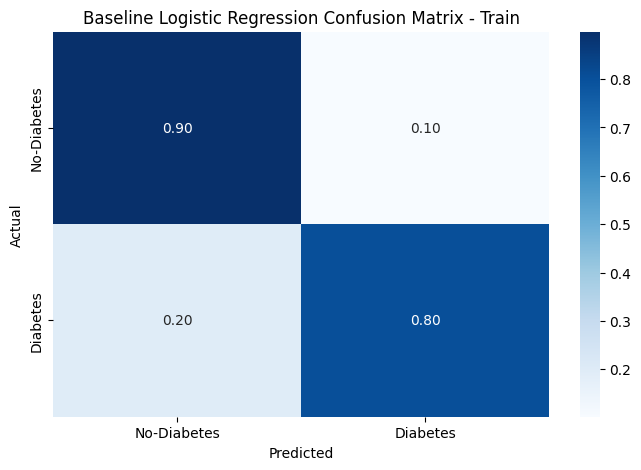

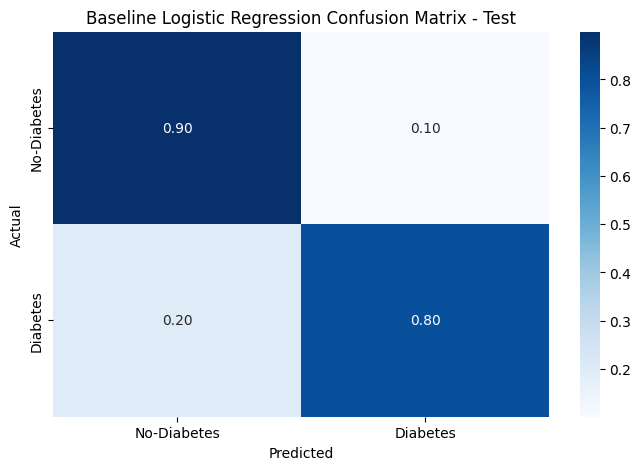

In [42]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline logistic regression - Train
train_pred = baseline_logreg.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline logistic regression - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Logistic Regression Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline logistic regression - Test
test_pred = baseline_logreg.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline logistic regression - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Logistic Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


In [43]:
#print classification Scores for the test set
y_pred = baseline_logreg.predict(X_test)
divider = ('-' * 60)
table = classification_report(y_test, y_pred, digits=3)

print('\n', 'Classification Report - Test', '\n')
print(divider)
print(table)


 Classification Report - Test 

------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.979     0.899     0.937     22805
           1      0.432     0.802     0.562      2191

    accuracy                          0.890     24996
   macro avg      0.706     0.850     0.750     24996
weighted avg      0.931     0.890     0.904     24996



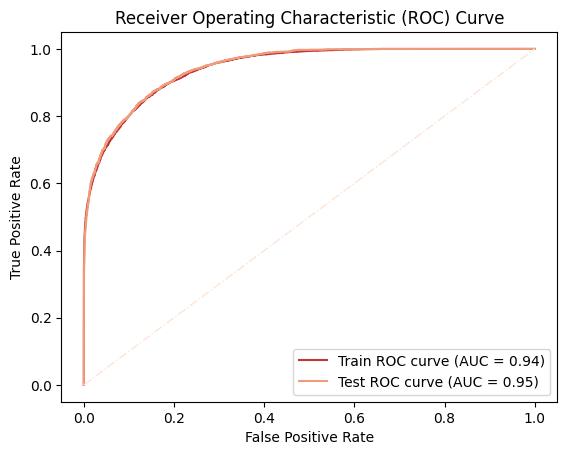

In [44]:
#quick look at the performance of our baseline model.  We'll take a peek
#at the ROC curve first, even though our metric of interest is recall, and F1.

#compute the predicted probabilities
y_prob_train = baseline_logreg.predict_proba(X_train)[:, 1]
y_prob_test = baseline_logreg.predict_proba(X_test)[:, 1]

#compute the false positive rate (fpr), true positive rate (tpr), and thresholds for train and test sets
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

#compute the area under the ROC curve (AUC) for train and test sets
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

#plot the ROC curve for train and test sets
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle='-.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

#Tuned Logisitic Regression

In [45]:
#parameters for our gridsearch, model optimization
parameters = {
    'estimator__penalty' : [ 'l2'],
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [20, 50, 100],
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'estimator__max_iter'  : [50, 100, 200, 300]
}

#create the grid, with "logreg_pipeline" as the estimator
best_logreg = GridSearchCV(estimator=baseline_logreg,
                          param_grid=parameters,
                          scoring='precision',
                          cv=5,
                          n_jobs=-1
)


In [46]:
#train the pipeline (tranformations & predictor)
best_logreg.fit(X_train, y_train);

#let's take a look at our best parameters
best_logreg.best_params_

{'estimator__C': 20,
 'estimator__fit_intercept': False,
 'estimator__max_iter': 50,
 'estimator__penalty': 'l2',
 'estimator__solver': 'newton-cg'}

In [49]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_logreg_roc_score_train = roc_auc_score(y_train, best_logreg.predict(X_train))
best_logreg_roc_score_test = roc_auc_score(y_test, best_logreg.predict(X_test))

#capture precision scores for test and train
best_logreg_precision_score_train_cv = cross_val_score(estimator=best_logreg, X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_logreg_precision_score_train = precision_score(y_train, best_logreg.predict(X_train))
best_logreg_precision_score_test = precision_score(y_test, best_logreg.predict(X_test))

#capture f1 scores for test and train
best_logreg_f1_score_train = f1_score(y_train, best_logreg.predict(X_train))
best_logreg_f1_score_test = f1_score(y_test, best_logreg.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_logreg_roc_score_train :.2%}")
print(f" Test ROC Score: {best_logreg_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_logreg_precision_score_train :.2%}")
print(f" Test Precision score: {best_logreg_precision_score_test :.2%}")
print(f" Mean Cross Validated Precision Score: {best_logreg_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {best_logreg_f1_score_train :.2%}")
print(f" Test F1 score: {best_logreg_f1_score_test :.2%}")
print(divider, '\n')

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 84.94%
 Test ROC Score: 85.02%
--------------------------------------------------
 Train Precision score: 43.01%
 Test Precision score: 44.22%
 Mean Cross Validated Precision Score: 43.03%
--------------------------------------------------
 Train F1 score: 55.84%
 Test F1 score: 56.88%
-------------------------------------------------- 



We saw a slight improvement in our tuned logistic regression model 44% vs 43%.  We are going to continue looking at additional models to see if we can improve upon this score.  I will display the comparison below for additional context.

In [50]:
print(f" Test Baseline Logreg Precision score: {baseline_logreg_precision_score_test :.2%}")
print(f" Test Tuned Logreg Precision score: {best_logreg_precision_score_test :.2%}")

 Test Baseline Logreg Precision score: 43.22%
 Test Tuned Logreg Precision score: 44.22%


#Baseline Decision Tree

In [51]:
# Baseline model
baseline_tree = ImPipeline(steps=[('sm', SMOTE(random_state=42)),
                                  ('scale', StandardScaler()),
                                  ('estimator', DecisionTreeClassifier(random_state=42))])

# Train model
baseline_tree.fit(X_train, y_train);

In [52]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
baseline_tree_roc_score_train = roc_auc_score(y_train, baseline_tree.predict(X_train))
baseline_tree_roc_score_test = roc_auc_score(y_test, baseline_tree.predict(X_test))

#capture precision scores for test and train
baseline_tree_precision_score_train_cv = cross_val_score(estimator=baseline_tree, X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

baseline_tree_precision_score_train = precision_score(y_train, baseline_tree.predict(X_train))
baseline_tree_precision_score_test = precision_score(y_test, baseline_tree.predict(X_test))

#capture f1 scores for test and train
baseline_tree_f1_score_train = f1_score(y_train, baseline_tree.predict(X_train))
baseline_tree_f1_score_test = f1_score(y_test, baseline_tree.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {baseline_tree_roc_score_train :.2%}")
print(f" Test ROC Score: {baseline_tree_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {baseline_tree_precision_score_train :.2%}")
print(f" Test Precision score: {baseline_tree_precision_score_test :.2%}")
print(f" Mean Cross Validated Precision Score: {baseline_tree_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {baseline_tree_f1_score_train :.2%}")
print(f" Test F1 score: {baseline_tree_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 99.60%
 Test ROC Score: 85.13%
--------------------------------------------------
 Train Precision score: 99.65%
 Test Precision score: 69.92%
 Mean Cross Validated Precision Score: 67.62%
--------------------------------------------------
 Train F1 score: 99.44%
 Test F1 score: 71.57%
-------------------------------------------------- 



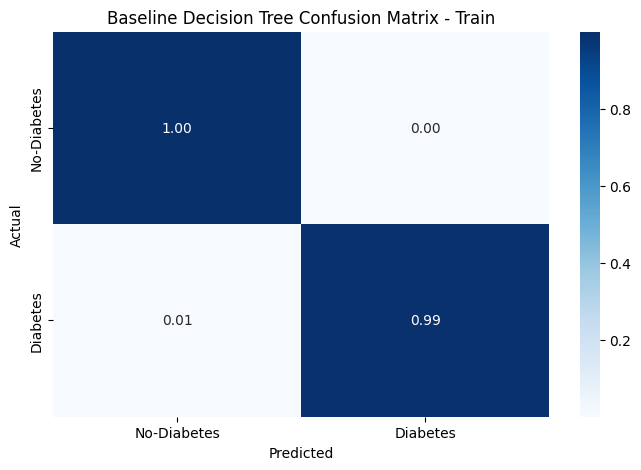

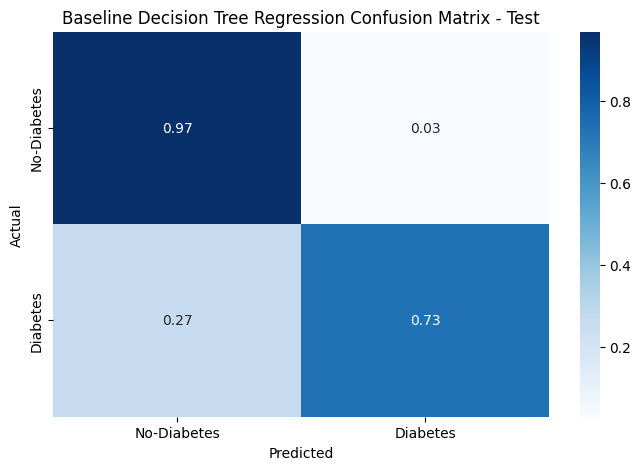

In [53]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the baseline decision tree - Train
train_pred = baseline_tree.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the baseline decision tree - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Decision Tree Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the baseline decision tree - Test
test_pred = baseline_tree.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the baseline decision tree - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Baseline Decision Tree Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


** Need insight here

Clealy overfitting, better performance than our baseline and tuned logreg models.

In [54]:
#let's tune this model!
parameters = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [3, 5, 10, 15, 20],
    'estimator__max_features': [None, 15,  5],
    'estimator__min_samples_split': [2, 5, 7, 10],
    'estimator__min_samples_leaf': [1, 2, 5]
            }

#grid with our baseline tree as our estimator
best_tree = GridSearchCV(estimator=baseline_tree,
                          param_grid=parameters,
                          scoring='precision',
                          cv=5,
                          n_jobs=-1
                        )



In [55]:
#train the pipeline based on our most appropriate parameters
best_tree.fit(X_train, y_train);
best_tree.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2}

In [56]:
#scoring print out adapted from others -- Eva Mizer, and Aysu Erdemir.
divider = ('-----' * 10)

#capture roc_auc for test, and train
best_tree_roc_score_train = roc_auc_score(y_train, best_tree.predict(X_train))
best_tree_roc_score_test = roc_auc_score(y_test, best_tree.predict(X_test))

#capture precision scores for test and train
best_tree_precision_score_train_cv = cross_val_score(estimator=best_tree, X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='precision').mean()

best_tree_precision_score_train = precision_score(y_train, best_tree.predict(X_train))
best_tree_precision_score_test = precision_score(y_test, best_tree.predict(X_test))

#capture f1 scores for test and train
best_tree_f1_score_train = f1_score(y_train, best_tree.predict(X_train))
best_tree_f1_score_test = f1_score(y_test, best_tree.predict(X_test))

print('\n', "Performance Comparison", '\n')
print(divider)
print(f" Train ROC Score: {best_tree_roc_score_train :.2%}")
print(f" Test ROC Score: {best_tree_roc_score_test :.2%}")
print(divider)

print(f" Train Precision score: {best_tree_precision_score_train :.2%}")
print(f" Test Precision score: {best_tree_precision_score_test :.2%}")
print(f" Mean Cross Validated Precision Score: {best_tree_precision_score_train_cv :.2%}")
print(divider)

print(f" Train F1 score: {best_tree_f1_score_train :.2%}")
print(f" Test F1 score: {best_tree_f1_score_test :.2%}")
print(divider, '\n')


 Performance Comparison 

--------------------------------------------------
 Train ROC Score: 83.40%
 Test ROC Score: 83.59%
--------------------------------------------------
 Train Precision score: 100.00%
 Test Precision score: 100.00%
 Mean Cross Validated Precision Score: 100.00%
--------------------------------------------------
 Train F1 score: 80.10%
 Test F1 score: 80.37%
-------------------------------------------------- 



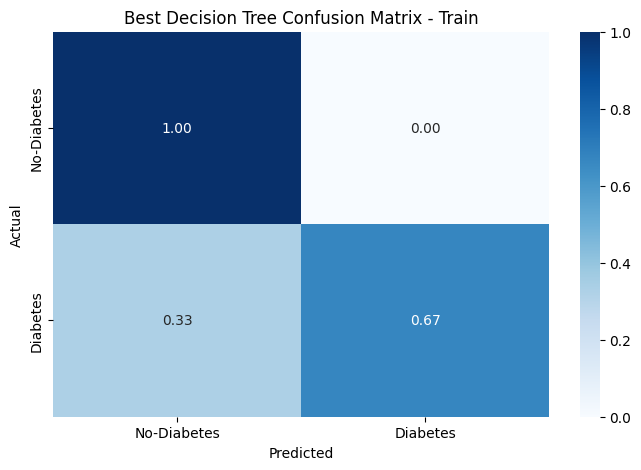

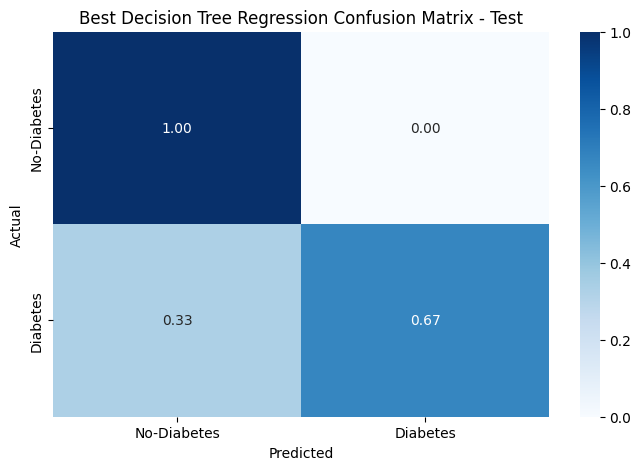

In [57]:
#define the labels for the confusion matrix
labels = ['No-Diabetes', 'Diabetes']

#compute the confusion matrix for the best decision tree - Train
train_pred = best_tree.predict(X_train)
train_cm = confusion_matrix(y_train, train_pred, normalize='true')

#plotting confusion matrix for the best decision tree - Train
plt.figure(figsize=(8, 5))
sns.heatmap(train_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Decision Tree Confusion Matrix - Train")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

#compute the confusion matrix for the best decision tree - Test
test_pred = best_tree.predict(X_test)
test_cm = confusion_matrix(y_test, test_pred, normalize='true')

#plotting confusion matrix for the best decision tree - Test
plt.figure(figsize=(8, 5))
sns.heatmap(test_cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Best Decision Tree Regression Confusion Matrix - Test")
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()


** Need insight here

In [59]:
print(f" Test Baseline Logreg Precision score: {baseline_logreg_precision_score_test :.2%}")
print(f" Test Tuned Logreg Precision score: {best_logreg_precision_score_test :.2%}")
print(f" Test Precision score: {baseline_tree_precision_score_test :.2%}")
print(f" Test Precision score: {best_tree_precision_score_test :.2%}")

 Test Baseline Logreg Precision score: 43.22%
 Test Tuned Logreg Precision score: 44.22%
 Test Precision score: 69.92%
 Test Precision score: 100.00%


** Further insight here; need to also evaluate secondary metric - such as F1 score.  I bet recall is suffering from this performance.

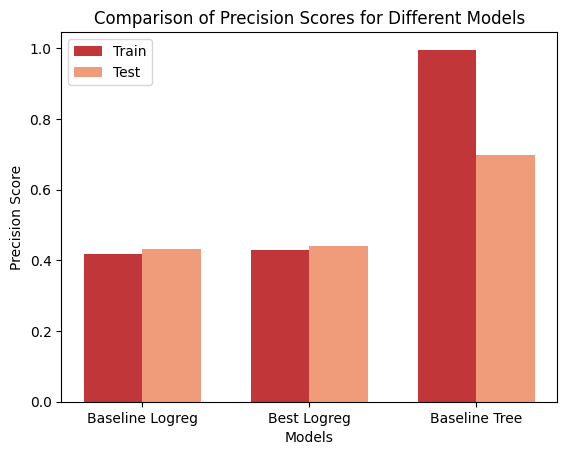

In [65]:
# Precision scores for different models
models = ['Baseline Logreg', 'Best Logreg', 'Baseline Tree']
train_precision_scores = [baseline_logreg_precision_score_train, best_logreg_precision_score_train, baseline_tree_precision_score_train]
test_precision_scores = [baseline_logreg_precision_score_test, best_logreg_precision_score_test, baseline_tree_precision_score_test]

# Create a bar chart
bar_width = 0.35
index = np.arange(len(models))  # Use np.arange instead of range

plt.bar(index, train_precision_scores, bar_width, label='Train')
plt.bar(index + bar_width, test_precision_scores, bar_width, label='Test')
plt.xlabel('Models')
plt.ylabel('Precision Score')
plt.title('Comparison of Precision Scores for Different Models')
plt.xticks(index + bar_width/2, models)
plt.legend()

# Display the chart
plt.show()
